In [81]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os
from torchvision.io import read_image
from PIL import Image



niftypath = "/mnt/c/Users/Patrick/Documents/MPHYS_DATA_NIFTY"
croppath = "/mnt/c/Users/Patrick/Documents/MPHYS_DATA_CROPPED"

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [217]:
idx = 0
transform = ToTensor()

class CustomImageDataset():
    def __init__(self, croppath, transform=None, target_transfrom=None):
        self.img_labels = os.listdir(croppath)
        self.img_dir = croppath
        self.transform=transform
        #print(self.transform)
        self.target_transform=target_transfrom

    def __len__ (self):
        return len(self.img_labels)

    def __get_item__ (self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        print(img_path)
        image = sitk.ReadImage(img_path)
        array = sitk.GetArrayFromImage(image)
        tensor = torch.from_numpy(array)
        #pil_img = Image.fromarray(array)
        label = self.img_labels[idx]
        # if self.transform(array):
        #     array = ToTensor(array)
        # if self.target_transform(label):
        #     label = self.target_transform(label)
        return(tensor,label)
dataset = []

for file in os.listdir(croppath):
    if "-RT" in file:
        image = sitk.ReadImage(os.path.join(croppath, file))
        array = sitk.GetArrayFromImage(image)
        dataset.append(array)

#dataset = CustomImageDataset(croppath, ToTensor(), None)
tensor = torch.tensor(dataset)
print(tensor.shape)

torch.Size([20, 172, 172, 172])


In [170]:
x = dataset[0]
print(np.argwhere(x))

[[ 55  69  78]
 [ 55  69  79]
 [ 55  69  80]
 ...
 [117  87  67]
 [117  87  68]
 [117  87  69]]


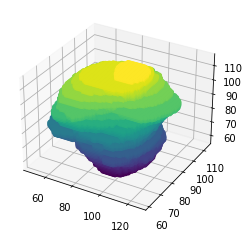

In [193]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
z,x,y = dataset[19].nonzero()
ax.scatter(x,y,z,c=z,alpha = 1)
plt.show()

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=20, shuffle=True)
train_features = next(iter(train_dataloader))
print(train_features.shape)
print(train_features.size)

In [220]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack()
        return logits
model = NeuralNetwork().to(device)
print(model)

logits = model(tensor)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"predicted_class:{y_pred}")

cpu
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


TypeError: forward() missing 1 required positional argument: 'input'

In [233]:
flatten = nn.Flatten()
#x = np.array(tensor[0])
#x = torch.tensor(x, dtype=torch.float32)
#print(x)
#print(x.shape)
flat_tensor = tensor[0].flatten(start_dim=0, end_dim=-1)

layer1 = nn.Linear(in_features=172*172*172, out_features=20)
hidden1 = layer1(flat_tensor)
print(hidden1)
hidden1 = nn.ReLU()(hidden1)
print(hidden1)

tensor([-0.0059,  0.0072,  0.0827,  0.0241, -0.1065,  0.1820, -0.0950,  0.0086,
         0.0079,  0.1463, -0.0107,  0.0735, -0.1773, -0.0520, -0.1743,  0.0215,
        -0.0589, -0.0503, -0.0424, -0.0243], grad_fn=<AddBackward0>)
tensor([0.0000, 0.0072, 0.0827, 0.0241, 0.0000, 0.1820, 0.0000, 0.0086, 0.0079,
        0.1463, 0.0000, 0.0735, 0.0000, 0.0000, 0.0000, 0.0215, 0.0000, 0.0000,
        0.0000, 0.0000], grad_fn=<ReluBackward0>)
